# Sensitivity Study of SOL 106's Nonlinear Analysis Parameters

In this notebook we investigate the effect of varying the nonlinear analysis parameters of MSC Natran SOL 106 on the load-displacement diagram of a box beam structure under a bending load.

* [Geometry and material properties](#properties)
* [Setup of the numerical model](#numerical-model)
* [Sensitivity analysis](#sensitivity)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
    * [Initial load increment](#ninc)
    * [Desired number of iteration](#desiter)
    * [Minimum allowable arc-length adjustment ratio](#minalr)
    * [Maximum allowable arc-length adjustment ratio](#maxalr)
* [Conclusions](#conclusions)

## Geometry and material properties <a name="properties"></a>

***

We consider the same box beam geometry and material properties of our [previous notebook](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#properties).

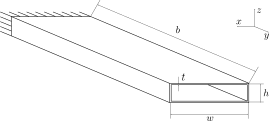

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

In [2]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


In [3]:
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

We discretize our box beam using the function `mesh_box` from the `box_beam_utils` module. We choose the size of the shell elements based on the mesh convergence results of our [previous notebook](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#mesh-convergence). Then we use the function `create_base_bdf_input` from the same module to create a base `BDF` object including material and element properties, nodes, quadrilateral shell elements, boundary conditions and some settings for the output files. Finally, we visualize the cards of our bdf input with the method `get_bdf_stats`.

In [4]:
from resources import box_beam_utils  # module with useful functions to work with box beam problems

edge_length = 86  # [mm]
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=edge_length)  # generate coordinates of the nodes and connectivity information
box_beam_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)  # create base BDF object
print(box_beam_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


To complete the setup of our numerical model, we need to define a load. We consider a concentrated bending load applied at the tip section, which is rigidly constrained. We choose this configuration among the different ones investigated in our previous notebook because it's the one that most shows a global beam-like behavior.

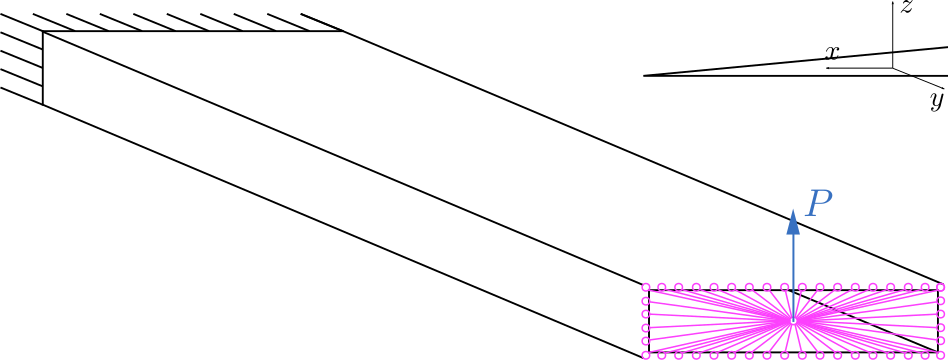

In [5]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

We define a master node at the center of the tip section and we rigidly constrain all the nodes along the tip section to the master node with a RBE2 element. Then we apply a unitary force along the $z$-axis at the master node using a FORCE card.

In [6]:
import numpy as np  # package to work with arrays and linear algebra

# Add RBE2 element to make tip section rigid
master_node_id = np.size(nodes_coordinates_array, 0) + 1  # define id of master node of tip section
box_beam_bdf_input.add_grid(master_node_id, [w/2, b, 0.])  # add GRID card to define master node of tip section
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)  # find the id of all nodes
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1]==b]  # find id of the nodes located at the tip section
rbe2_eid = len(box_beam_bdf_input.elements) + 1  # define id of the RBE2 element
box_beam_bdf_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)  # add RBE2 card

# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

FORCE         11    1761              1.      0.      0.      1.

## Sensitivity analysis <a name="sensitivity"></a>

***

Now we want to evaluate the influence of SOL 106's nonlinear analysis parameters on the results of the analysis. We are going to assess this observing how the load-displacement curve changes with the value of each considered parameter.

We first set up the nonlinear analysis with the arc-length method using the function `set_up_arc_length_method` from the `pynastran_utils` module. We use default parameters to run a reference analysis.

In [7]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

pynastran_utils.set_up_arc_length_method(box_beam_bdf_input)  # set up SOL 106 with arc-length method using default parameters

We recall the buckling load predicted by SOL 105 from our [previous notebook](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#concentrated-load-rigid-tip) and we create a subcase where we apply such load to our box beam. Finally, we run the analysis and we plot both the load-displacement diagram and the structural deformation at the end of the analysis.

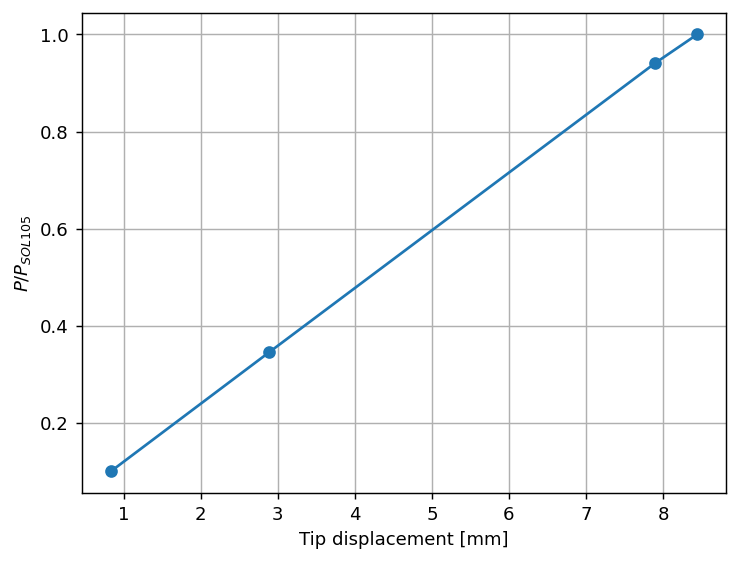

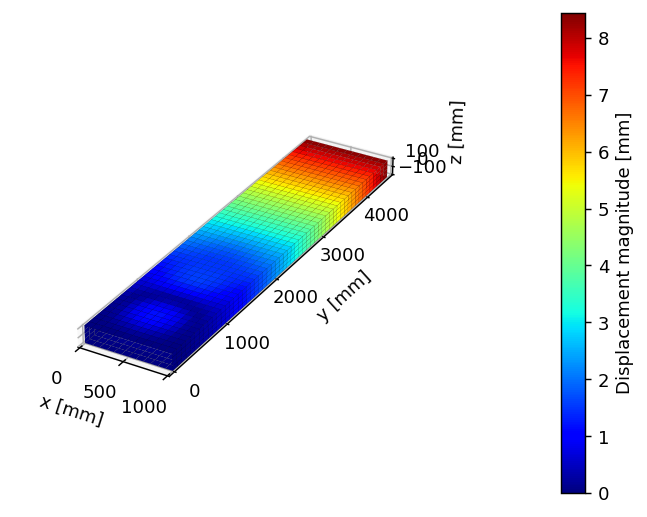

In [8]:
import matplotlib.pyplot as plt  # plotting package
from pyNastran.op2.op2 import read_op2  # function to read Nastran op2 files

# Create subcase where we apply the buckling load predicted by SOL 105
sol_105_buckling_load = 1657.  # [N]
load_set_id = force_set_id + 1  # define id of load set
box_beam_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[sol_105_buckling_load], load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set

# Run analysis
analysis_directory_name = '05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
input_filename = 'nonlinear_analysis_reference'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None, load_geometry=True)

# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)

# Plot load-displacement diagram
plt.rcParams['figure.dpi'] = 120  # default dpi of figures
load_component_index = 2  # select load along z-axis
displacement_component_index = 2  # select displacement along z-axis
_, ax = plt.subplots()  # create figure with one subplot
ax.plot(displacements[1][:,displacement_component_index], loads[1][:, load_component_index]/sol_105_buckling_load, 'o-')  # plot load vs displacement
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()

# Plot structural deformation at the last converged iteration
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, displacement_component='tz')
ax.locator_params(axis='x', nbins=3)  # number of x-axis ticks
ax.locator_params(axis='z', nbins=2)  # number of z-axis ticks
ax.tick_params(axis='y', which='major', pad=20)  # distance of y-axis tick labels
ax.tick_params(axis='z', which='major', pad=6)  # distance of z-axis tick labels
ax.yaxis.labelpad = 60  # distance of y-axis label
ax.zaxis.labelpad = 10  # distance of z-axis label
plt.show()

The load-displacement diagram appears to be linear, suggesting that the nonlinear analysis parameters should not have any influence on the results for the load range investigated here. However, the final deformation of the structure indicates the presence of a buckled-like shape, suggesting that nonlinearity may come into play.

### Error function <a name="error-function"></a>

The first parameter that we are going to investigate is the error function, defined by the CONV field of the NLPARM card. The choice of the error functions determines how convergence is checked for every load increment. Three different error functions are available in Nastran:
- energy error $E_w$
$$E_w=\frac{\left|\mathbf{R}\cdot\mathbf{\Delta u}\right|}{E^*},$$
- load error $E_p$
$$E_p=\frac{\left|\mathbf{R}\cdot\mathbf{u}\right|}{\left|\mathbf{P^\prime}\cdot\mathbf{u}\right|},$$
- displacement error $E_u$
$$E_u=\frac{q}{1-q}\frac{\left|\mathbf{w}\cdot\mathbf{\Delta u}\right|}{\left|\mathbf{w}\cdot\mathbf{u}\right|}.$$

In the above expressions $| ... |$ represents the vector norm, that is to say $|\mathbf{x}|=\sum_{r=1}^n |x_r|$, $\mathbf{R}$ represents the vector of out-of-balance forces (residual), $\mathbf{\Delta u}$ represents the vector of incremental displacements at the current iteration, $E^*=\left|\mathbf{P^\prime}\cdot\mathbf{u}\right|$ is the reference energy, with $\mathbf{P^\prime}=\mathbf{\Delta P} + \mathbf{P}$. $\mathbf{u}$ and $\mathbf{\Delta P}$ are respectively the displacement vector and the incremental load vector at the current iteration, while $\mathbf{P}$ is the total load at the previous loading step. Finally, $\mathbf{w}$ is a weighting function formed by collecting the square root of the diagonal terms of the stiffness matrix and $q$ is a contraction factor defined as the ratio of displacement increments between two successive steps. For more details please refer to the [_NX Nastran Handbook of Nonlinear Analysis (Solutions 106 and 129)_ manual](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://docs.plm.automation.siemens.com/data_services/resources/nxnastran/10/help/en_US/custom/nonlinear_106/nonlinear_106_NXN.pdf).

We are going to consider four different combinations of error functions:
- load and energy (default);
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking.

Vector component checking consists in performing the convergence checking on the maximum vector component of all components in the model.

Let's define the list of the test flags corresponding to the mentioned combinations of functions.

In [9]:
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']

Since we need to plot the load-displacement diagram for different values of the nonlinear analysis parameters, we define a list of markers to use in the plots. We also define the function `plot_load_displacement_curve` to run the Nastran analysis, read the load and displacement history from the op2 file and plot the load-displacement curve on a pre-defined figure.

In [10]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

markers = list(Line2D.markers.keys())[2:]  # list of marker characters

def plot_load_displacement_curve(bdf_input, filename, axes, marker_style, line_label):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=False)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    _, p, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=master_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,displacement_component_index], p[1][:, load_component_index]/sol_105_buckling_load, marker=marker_style, linestyle='-', label=line_label)

Now we can run the analyses for the different combinations of error functions and plot the results.

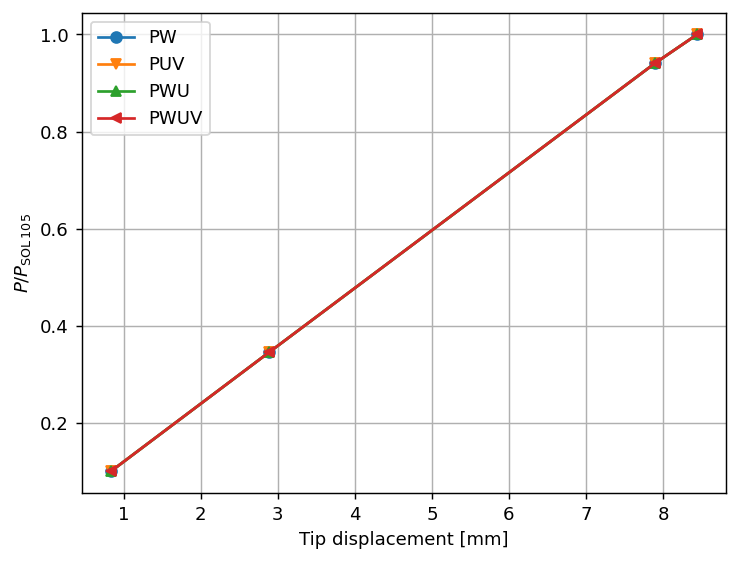

In [11]:
nlparm_id = next(iter(box_beam_bdf_input.nlparms))  # retrieve id of NLPARM card
_, ax = plt.subplots()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf_input.nlparms[nlparm_id].conv = fun
    input_filename = 'nonlinear_analysis_error_function_' + fun
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'{fun}')

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

The results do not appear to be influenced by the error functions. This suggests that the buckled-like shape observed earlier in the deformation plot develops only at the end of the load range investigated, so no nonlinear behavior can be observed. As a consequence the behavior of the structure is linear and the nonlinear parameters cannot have any effect on the load-displacement curve. For this reason, we restore the default load and energy error functions combination.

In [12]:
box_beam_bdf_input.nlparms[nlparm_id].conv = 'PW'

### Convergence tolerance <a name="convergence-tolerance"></a>

The second parameter that we are going to consider is the convergence tolerance, which corresponds to the value of the error function that determines the convergence of the load increment iteration. The convergence tolerance is defined by the EPSP and the EPSW fields of the NLPARM card for the load and energy function, respectively.

We are going to consider three different combinations of convergence tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL 106 models :
- $EPSP=10^{-1}$, $EPSW=10^{-1}$;
- $EPSP=10^{-2}$, $EPSW=10^{-3}$;
- $EPSP=10^{-3}$, $EPSW=10^{-7}$,

where the default values are $EPSP=10^{-2}$ and $EPSW=10^{-2}$.

Let's define the list of convergence tolerances, run the analyses and visualize the results.

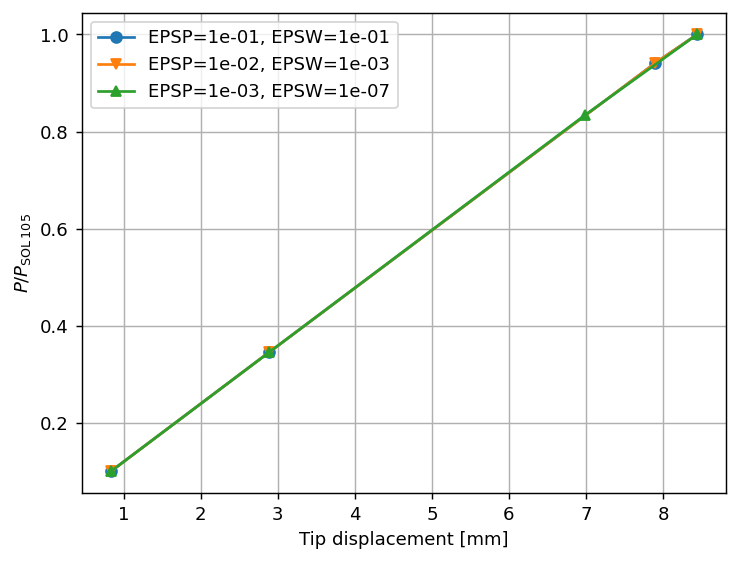

In [13]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
_, ax = plt.subplots()
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf_input.nlparms[nlparm_id].eps_p = epsp
    box_beam_bdf_input.nlparms[nlparm_id].eps_w = epsw
    input_filename = f'nonlinear_analysis_load_tolerance_{epsp:.3f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}')

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

As expected, also in this case the results do not show any dependece on the considered parameter, so we switch back to the default values.

In [14]:
box_beam_bdf_input.nlparms[nlparm_id].eps_p = 1e-2
box_beam_bdf_input.nlparms[nlparm_id].eps_w = 1e-2

### Initial load increment <a name="initial-load-increment"></a>

Now we consider the initial load increment, which is related to the field NINC of the NLPARM card. When using the arc-length method, as in our case, the initial load increment $\Delta\mu^1$ is defined as:
$$\Delta\mu^1=\frac{1}{NINC},$$

where $NINC$ represents the number of increments in a nonlinear analysis employing the Newton method with constant load increments.

We are going to consider three values for the initial load increment:
- $\Delta\mu^1=0.5$;
- $\Delta\mu^1=0.1$ (default);
- $\Delta\mu^1=0.01$.

Let's define the list of initial load increments, run the analyses and visualize the results.

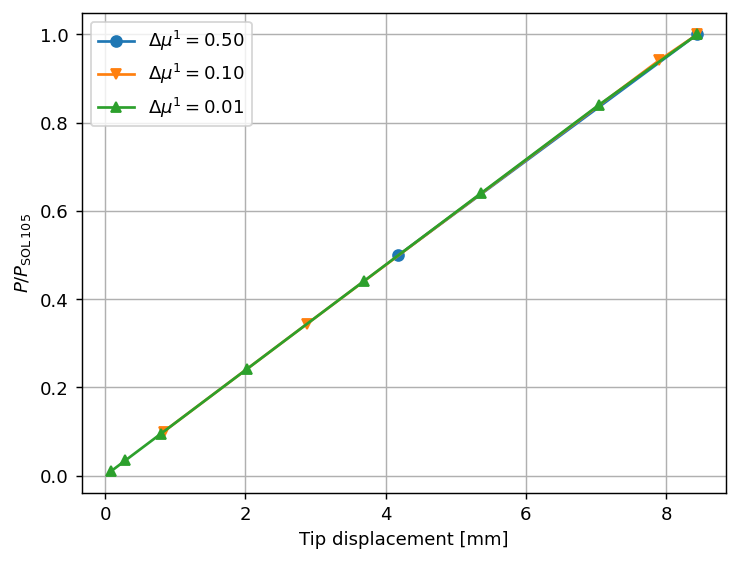

In [15]:
initial_load_increments = [.5, .1, .01]  # define list of initial load increments

# Create figure, run analysis for each initial load increment and plot load-displacement diagram
_, ax = plt.subplots()
for count, delta_mu_1 in enumerate(initial_load_increments):
    box_beam_bdf_input.nlparms[nlparm_id].ninc = int(1/delta_mu_1)
    input_filename = f'nonlinear_analysis_initial_load_increment_{delta_mu_1:.2f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'$\Delta\mu^1={delta_mu_1:.2f}$')

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

We observe that a smaller initial load increment results in a better resolution of the load-displacement curve, but the curve itself is not affected by the change in the initial load increment. As a consequence we restore the default value of the NINC field.

In [16]:
box_beam_bdf_input.nlparms[nlparm_id].ninc = 10

### Desired number of iterations <a name="desiter"></a>

Now we want to vary the desired number of iteration $I_d$, defined by the DESITER field of the NLPCI card. This parameter controls how the arc-length $\Delta l$ is updated between successive load increments:
$$\Delta l_{new}=\sqrt{\frac{I_d}{I_{max}}}\Delta l_{old},$$
where $I_{max}$ is the number of iterations required for convergence at the preceding step.

We are going to consider three values of desired number of iterations:
- $I_d=20$;
- $I_d=12$ (default);
- $I_d=5$.

Let's define the list of desired number of iterations, run the analyses and visualize the results.

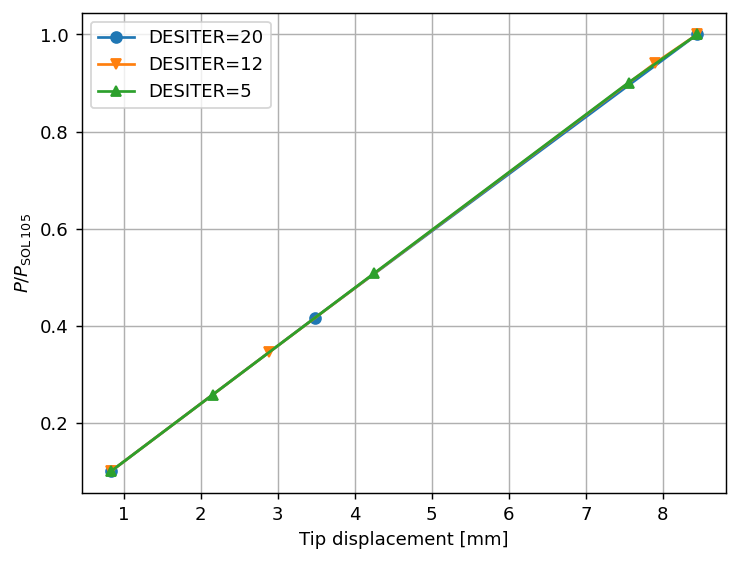

In [17]:
no_iterations = [20, 12, 5]  # define list of desired numbers of iterations

# Create figure, run analysis for each desired number of iterations, plot load-displacement diagram
_, ax = plt.subplots()
for count, desiter in enumerate(no_iterations):
    box_beam_bdf_input.nlpcis[nlparm_id].desiter = desiter
    input_filename = 'nonlinear_analysis_desiter_' + str(desiter)
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'DESITER={desiter}')

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

We observe that a smaller number of desired number of iterations produces a load-equilibrium diagram with more resolution. However, once again the curve does not appear to have any notable change, so we restore the default value.

In [18]:
box_beam_bdf_input.nlpcis[nlparm_id].desiter = 12

### Minimum allowable arc-length adjustment ratio <a name="minalr"></a>

Next, we investigate the effect of the minimum allowable arc-length adjustment ratio, defined by the MINALR field of the NLPCI card. The arc-length adjustment ratio $\Delta l_{new}/\Delta l_{old}$ is bound in the following way:
$$MINALR<\frac{\Delta l_{new}}{\Delta l_{old}}<MAXALR.$$

We investigate three values of minimum allawable arc-length adjustment ratio:
- $MINALR=0.9$;
- $MINALR=0.25$ (default);
- $MINALR=0.01$.

Let's define the list of values, run the analyses and visualize the results.

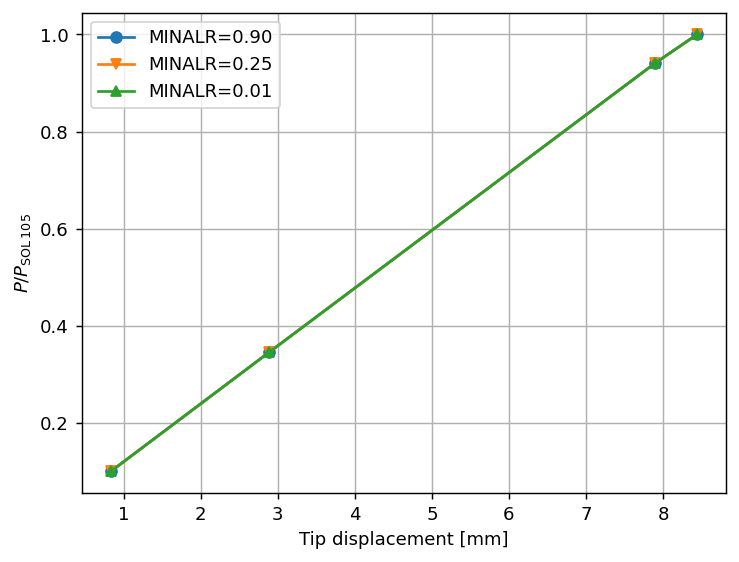

In [19]:
min_arclength_adjustment_ratios = [.9, .25, .01]  # define list of minimum allowable arc-length adjustment ratios

# Create figure, run analysis for each minimum allowable arc-length adjustment ratio and plot load-displacement diagram
_, ax = plt.subplots()
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[nlparm_id].minalr = minalr
    input_filename = f'nonlinear_analysis_minalr_{minalr:.2f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'MINALR={minalr:.2f}')

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

Also in this case we cannot see any effect on the load-displacement curve, as expected, so we switch back to the default value.

In [20]:
box_beam_bdf_input.nlpcis[nlparm_id].minalr = .25

### Maximum allowable arc-length adjustment ratio <a name="maxalr"></a>

Finally, we consider the maximum allowable arc-length adjustment ratio, defined by the MAXALR field of the NLPCI card. We consider three values:
- $MAXALR=10$;
- $MAXALR=4$ (default);
- $MAXALR=1.1$.

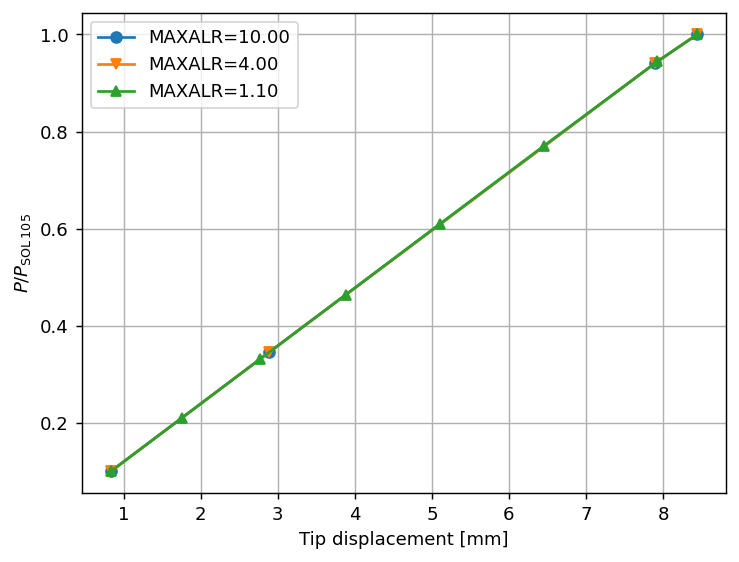

In [21]:
max_arclength_adjustment_ratios = [10., 4., 1.1]  # define list of maximum allowable arc-length adjustment ratios

# Create figure, run analysis for each maximum allowable arc-length adjustment ratio and plot load-displacement diagram
_, ax = plt.subplots()
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[nlparm_id].maxalr = maxalr
    input_filename = f'nonlinear_analysis_maxalr_{maxalr:.1f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'MAXALR={maxalr:.2f}')

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

We observe that a lower value of maximum allowable arc-length adjustment ratio results in a curve with more resolution, but the curve itself is once again not affected by the different values of the parameter.

## Conclusions <a name="conclusions"></a>

***

In this notebook we have investigated the influence of SOL 106's nonlinear analysis parameters on the load-displacement diagram of a box beam loaded with a concentrated bending load at the tip. We applied a load equal to the buckling load predicted by SOL 105 and we found a linear load-displacement curve. As a consequence the variation of the nonlinear analysis parameters investigated did not show any effect on the curve.

Based on the mentioned evidence, we can conclude that [the results obtained with SOL 106's nonlinear buckling method](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb) do not depend on the nonlinear analysis parameters. In our [next notebook](06_Nonlinear_Buckling_Method_Verification.ipynb) we are going to continue our investigation on the validity of SOL 106's nonlinear buckling method.